# Deep learning Classifier

Train a classifier to recognize a run from a walk.

## Data loading and solve unbalanced dataset problem

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
os.chdir("../")
from data_preprocessing.create_dataset import Dataset3dAcc
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.ticker import PercentFormatter

In [2]:
from tensorflow.keras.layers import Conv2D, Dropout, Input, Dense, MaxPool2D, Flatten
from tensorflow.keras.models import Model

In [3]:
sequence_size = 10
batch_size = 1024
path_data = "data/clean/"

In [4]:
xtrain = Dataset3dAcc(sequence_length=sequence_size, batch_size=batch_size, amplitude=4, scale_batch=False)
xtrain.add_folder(path_data)

In [5]:
def scale_batch(batch):
    """Divide each record by the max"""
    m = np.max(np.abs(batch), axis=(1,2))
    for i in range(sequence_size):
        batch[:, i, 0] /= m
        batch[:, i, 1] /= m
        batch[:, i, 2] /= m
    
    return batch

In [6]:
def vis_metrics(hist, metric):
    if metric in hist.history.keys():
        plt.plot(hist.history[metric], label="training")
        plt.plot(hist.history['val_' + metric], label="validation")
        plt.title('model ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend()
        fig = plt.gcf()
        fig.set_size_inches(10, 4)

## Create train, test and validation sample

In [7]:
xval, yval = xtrain.get_validation_data(test_size=0.2)
xtest, ytest = xtrain.get_validation_data(test_size=0.2)

In [8]:
_ = np.where(xtrain.y == 1)  # Unbalance dataset : double the record when run
xtrain.x = np.concatenate([xtrain.x, xtrain.x[_]], axis=0)
xtrain.y = np.concatenate([xtrain.y, xtrain.y[_]], axis=0)

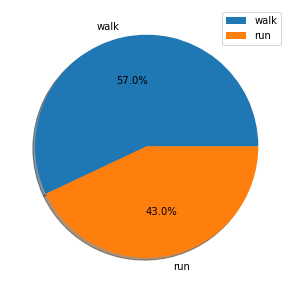

In [9]:
plt.pie([xtrain.y.shape[0] - np.sum(xtrain.y), np.sum(xtrain.y)], labels=('walk', "run"), shadow=True, autopct='%1.1f%%')
fig = plt.gcf()
plt.legend()
fig.set_size_inches(5, 6)

## CNN

Train a convolutional neural network using 10 records.<br>
10 records  $\approx$ 3s

### No scale of the data

In [10]:
def build_conv(sequence_size):
    """"""
    inputs = Input((sequence_size, 3, 1), name="input_layers")
    
    
    x = Conv2D(kernel_size=(4,3), strides=1, activation="relu", padding="same", filters=8)(inputs)
    x = MaxPool2D(2)(x)
    x = Dropout(0.1)(x)
    x = Conv2D(kernel_size=(4,1), strides=1, activation="relu", padding="same", filters=16)(x)
    x = MaxPool2D((2,1))(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid", name="output_layer")(x)
    
    return Model(inputs, x, name="convolutional")

In [11]:
conv10 = build_conv(sequence_size)
conv10.summary()

Model: "convolutional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layers (InputLayer)    [(None, 10, 3, 1)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 3, 8)          104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 1, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 1, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 1, 16)          528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 1, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 1, 16)        

In [12]:
conv10.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer="adam")
hist10 = conv10.fit(x=xtrain, steps_per_epoch=300, epochs=10, validation_data=(xval, yval), verbose=1)

Epoch 1/10
300/300 [==============================] - 5s 17ms/step - loss: 0.3290 - accuracy: 0.8464 - val_loss: 0.0972 - val_accuracy: 0.9692
Epoch 2/10
300/300 [==============================] - 5s 16ms/step - loss: 0.1055 - accuracy: 0.9615 - val_loss: 0.0502 - val_accuracy: 0.9850
Epoch 3/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0721 - accuracy: 0.9753 - val_loss: 0.0369 - val_accuracy: 0.9891
Epoch 4/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0549 - accuracy: 0.9823 - val_loss: 0.0282 - val_accuracy: 0.9916
Epoch 5/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0428 - accuracy: 0.9864 - val_loss: 0.0217 - val_accuracy: 0.9932
Epoch 6/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0357 - accuracy: 0.9889 - val_loss: 0.0178 - val_accuracy: 0.9946
Epoch 7/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0304 - accuracy: 0.9905 - val_loss: 0.0161 - val_accuracy: 0.9953

In [13]:
conv10.evaluate(xtest, ytest)

278/278 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.9947


[0.016710616648197174, 0.9947102069854736]

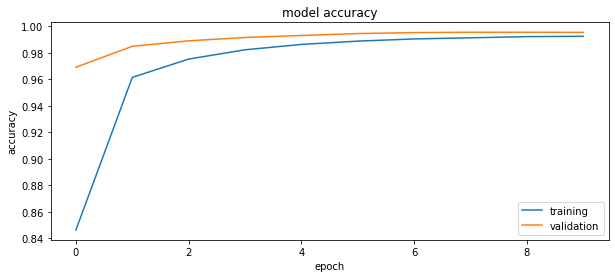

In [14]:
vis_metrics(hist=hist10, metric="accuracy")

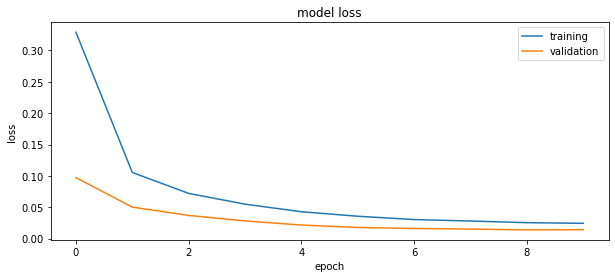

In [15]:
vis_metrics(hist=hist10, metric="loss")

In [16]:
confusion_matrix(ytest,np.where(conv10.predict(xtest) >.5, 1, 0))

array([[6398,   19],
       [  28, 2440]])

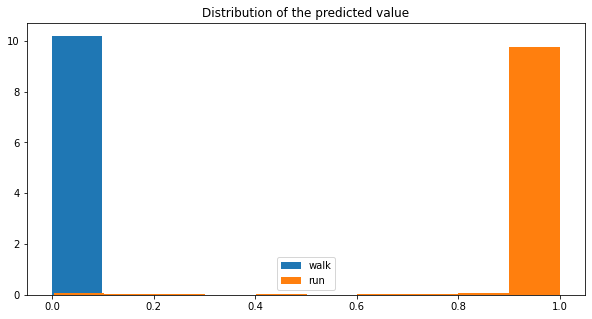

In [17]:
_ = plt.hist(conv10.predict(xtest)[np.where(ytest == 0.)[0]], label="walk", density=True)
_ = plt.hist(conv10.predict(xtest)[np.where(ytest == 1.)[0]], label="run", density=True)
_ = plt.title("Distribution of the predicted value")
_ = plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

### Scale the data

In [18]:
xtrain.set_scale_batch(True)  # Scale each record

In [19]:
conv10_scale = build_conv(sequence_size)
conv10_scale.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer="adam")
hist10_scale = conv10_scale.fit(x=xtrain, steps_per_epoch=300, epochs=10, validation_data=(scale_batch(xval), yval), verbose=1)

Epoch 1/10
300/300 [==============================] - 6s 19ms/step - loss: 0.2805 - accuracy: 0.8717 - val_loss: 0.0920 - val_accuracy: 0.9749
Epoch 2/10
300/300 [==============================] - 5s 16ms/step - loss: 0.1025 - accuracy: 0.9639 - val_loss: 0.0553 - val_accuracy: 0.9843
Epoch 3/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0773 - accuracy: 0.9727 - val_loss: 0.0483 - val_accuracy: 0.9847
Epoch 4/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0654 - accuracy: 0.9770 - val_loss: 0.0433 - val_accuracy: 0.9857
Epoch 5/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0596 - accuracy: 0.9790 - val_loss: 0.0450 - val_accuracy: 0.9850
Epoch 6/10
300/300 [==============================] - 5s 16ms/step - loss: 0.0537 - accuracy: 0.9811 - val_loss: 0.0401 - val_accuracy: 0.9855
Epoch 7/10
300/300 [==============================] - 5s 17ms/step - loss: 0.0514 - accuracy: 0.9823 - val_loss: 0.0407 - val_accuracy: 0.9863

In [20]:
conv10_scale.evaluate(scale_batch(xtest), ytest)

278/278 [==============================] - 0s 1ms/step - loss: 0.0384 - accuracy: 0.9855


[0.03842437267303467, 0.9854811429977417]

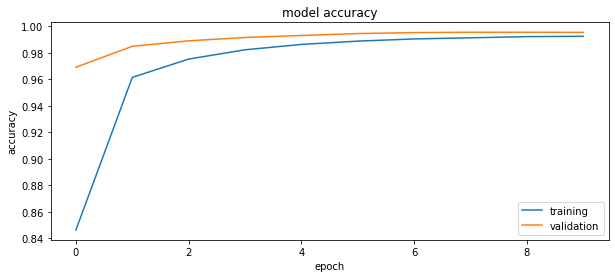

In [21]:
vis_metrics(hist=hist10, metric="accuracy")

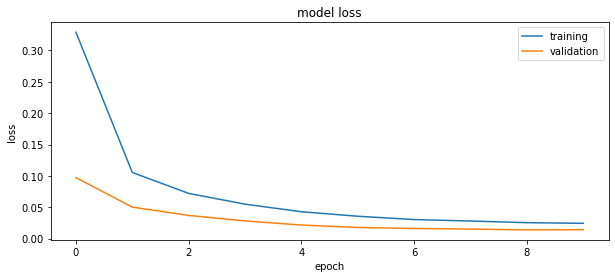

In [22]:
vis_metrics(hist=hist10, metric="loss")

In [23]:
confusion_matrix(ytest,np.where(conv10_scale.predict(scale_batch(xtest)) >.5, 1, 0))

array([[6357,   60],
       [  69, 2399]])

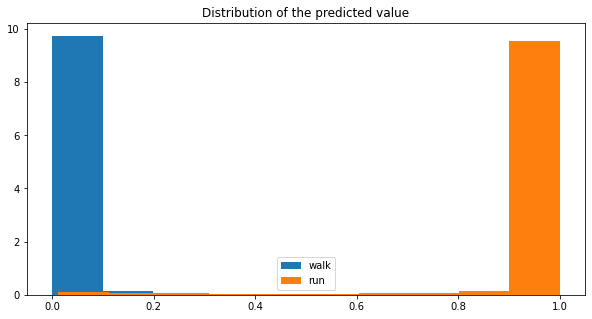

In [24]:
_ = plt.hist(conv10_scale.predict(scale_batch(xtest))[np.where(ytest == 0.)[0]], label="walk", density=True)
_ = plt.hist(conv10_scale.predict(scale_batch(xtest))[np.where(ytest == 1.)[0]], label="run", density=True)
_ = plt.title("Distribution of the predicted value")
_ = plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [25]:
conv10_scale.save("analysis/trained_model/conv/conv.h5")  # Save the trained model

## Create tf-lite  models

### tf lite model

In [26]:
xtest = scale_batch(xtest)

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(conv10_scale)
tflite_model = converter.convert()
_ = open("analysis/trained_model/conv/conv10_lite.tflite", "wb").write(tflite_model)  # Save the tf-lite model

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpa0m3gb9n/assets


In [28]:
interpreter = tf.lite.Interpreter("analysis/trained_model/conv/conv10_lite.tflite")  # Load the lite model
interpreter.allocate_tensors()

In [29]:
input_details = interpreter.get_input_details()[0]['index']
output_details = interpreter.get_output_details()[0]['index']

In [30]:
y = []
for _ in xtest:
    x = tf.convert_to_tensor([_], dtype=tf.float32)
    interpreter.set_tensor(input_details, x)
    interpreter.invoke()
    y += [interpreter.get_tensor(output_details)[0][0]]

y = np.array(y)

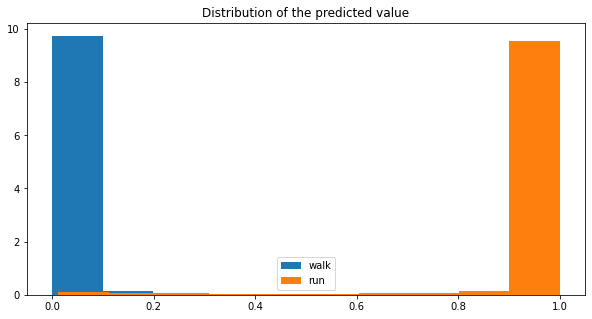

In [31]:
_ = plt.hist(y[np.where(ytest == 0.)[0]], label="walk", density=True)
_ = plt.hist(y[np.where(ytest == 1.)[0]], label="run", density=True)
_ = plt.title("Distribution of the predicted value")
_ = plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [32]:
confusion_matrix(ytest, np.where(y >.5, 1, 0))

array([[6357,   60],
       [  69, 2399]])

In [33]:
print("Model size: {}kb".format(os.stat("analysis/trained_model/conv/conv10_lite.tflite").st_size))

Model size: 7800kb


- tf lite model with size optimization

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(conv10_scale)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
_ = open("analysis/trained_model/conv/conv10_lite_optz.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzr2s9ki7/assets
INFO:tensorflow:Assets written to: /tmp/tmpzr2s9ki7/assets


In [35]:
interpreter = tf.lite.Interpreter("analysis/trained_model/conv/conv10_lite_optz.tflite")  # Load the lite model
interpreter.allocate_tensors()

In [36]:
input_details = interpreter.get_input_details()[0]['index']
output_details = interpreter.get_output_details()[0]['index']

In [37]:
y = []
for _ in xtest:
    x = tf.convert_to_tensor([_], dtype=tf.float32)
    interpreter.set_tensor(input_details, x)
    interpreter.invoke()
    y += [interpreter.get_tensor(output_details)[0][0]]

y = np.array(y)

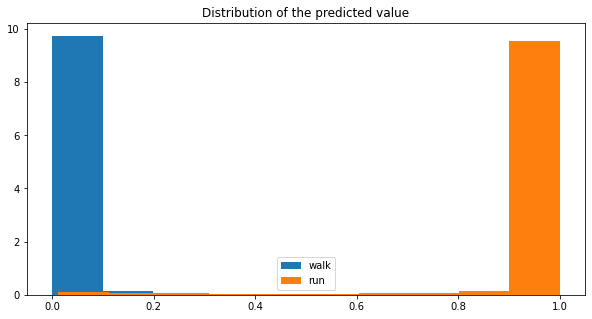

In [38]:
_ = plt.hist(y[np.where(ytest == 0.)[0]], label="walk", density=True)
_ = plt.hist(y[np.where(ytest == 1.)[0]], label="run", density=True)
_ = plt.title("Distribution of the predicted value")
_ = plt.legend()
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [39]:
confusion_matrix(ytest, np.where(y >.5, 1, 0))

array([[6357,   60],
       [  69, 2399]])

In [40]:
print("Model size: {}kb".format(os.stat("analysis/trained_model/conv/conv10_lite_optz.tflite").st_size))

Model size: 8000kb
